Dataset shape: (8500, 53)
Vehicle types and counts: 
vehicle_type
Car           3500
Motorcycle    2000
Truck         1500
Van           1500
Name: count, dtype: int64
Missing values: 
0


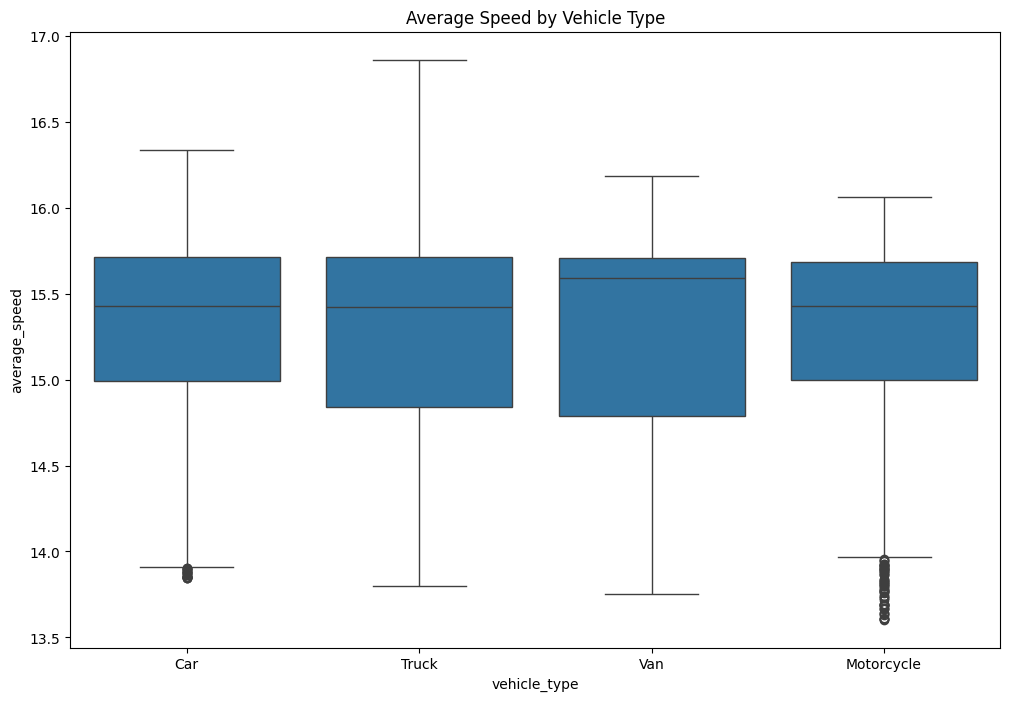

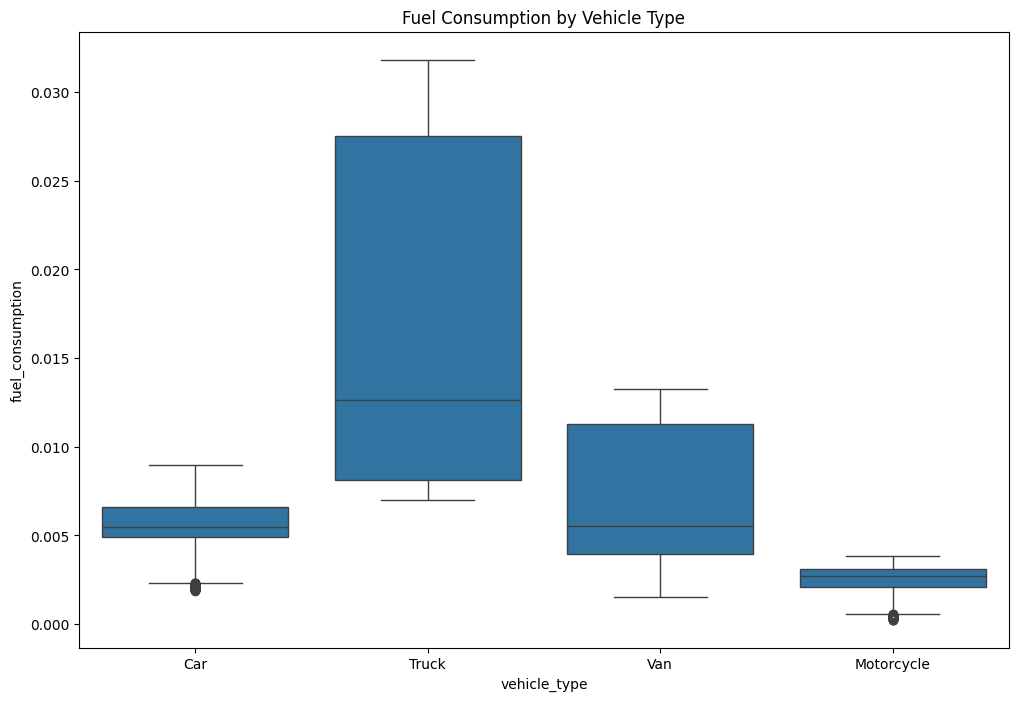

Encoded class mapping: {'Car': 0, 'Motorcycle': 1, 'Truck': 2, 'Van': 3}


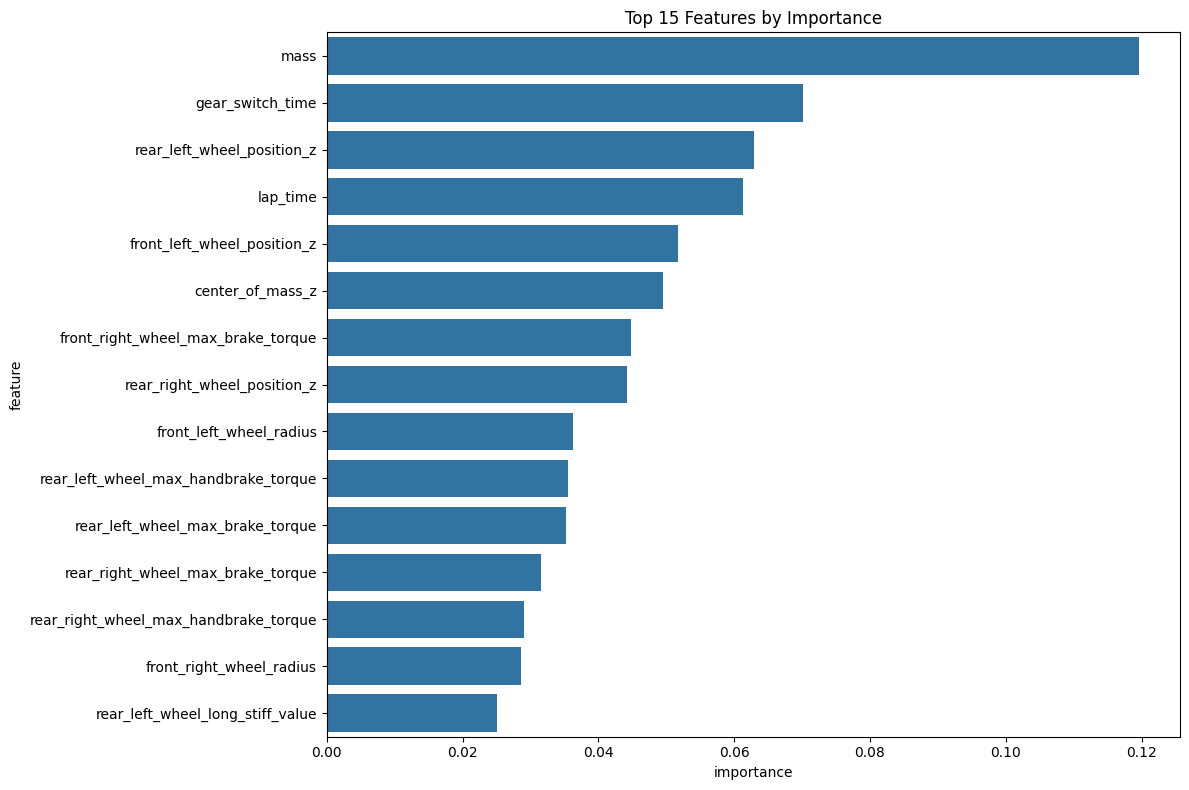

Selected features: Index(['fuel_consumption', 'total_steering', 'lap_time', 'mass',
       'center_of_mass_x', 'center_of_mass_z', 'gear_switch_time',
       'front_left_wheel_radius', 'front_left_wheel_max_brake_torque',
       'front_left_wheel_long_stiff_value', 'front_left_wheel_position_z',
       'front_right_wheel_radius', 'front_right_wheel_max_brake_torque',
       'front_right_wheel_long_stiff_value', 'front_right_wheel_position_z',
       'rear_left_wheel_radius', 'rear_left_wheel_max_brake_torque',
       'rear_left_wheel_max_handbrake_torque',
       'rear_left_wheel_long_stiff_value', 'rear_left_wheel_position_z',
       'rear_right_wheel_radius', 'rear_right_wheel_max_brake_torque',
       'rear_right_wheel_max_handbrake_torque',
       'rear_right_wheel_long_stiff_value', 'rear_right_wheel_position_z'],
      dtype='object')
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best parameters for Random Forest: {'max_depth': None, 'min_samples_split': 2, 'n_est

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.feature_selection import SelectFromModel
import xgboost as XGB

# Load dataset
df = pd.read_csv("./Extended_Lap_Data_Updated_unique_v5.csv")

# Basic data exploration
print(f"Dataset shape: {df.shape}")
print(f"Vehicle types and counts: \n{df['vehicle_type'].value_counts()}")
print(f"Missing values: \n{df.isnull().sum().sum()}")

# Handle any missing values if they exist
df = df.dropna()

# Exploratory data analysis - visualize relationship between features and vehicle type
plt.figure(figsize=(12, 8))
sns.boxplot(x='vehicle_type', y='average_speed', data=df)
plt.title('Average Speed by Vehicle Type')
plt.show()

plt.figure(figsize=(12, 8))
sns.boxplot(x='vehicle_type', y='fuel_consumption', data=df)
plt.title('Fuel Consumption by Vehicle Type')
plt.show()

# Create feature matrix and target vector
X = df.drop(columns=['vehicle_type', 'vehicle_name', 'lap'])  # Remove unnecessary columns
y = df['vehicle_type']

# Convert lap time to numeric if not already
if 'lap time' in X.columns:
    X = X.rename(columns={'lap time': 'lap_time'})

# Encode categorical variables if any remain
categorical_cols = X.select_dtypes(include=['object']).columns
for col in categorical_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])

# Encode the target variable
le_target = LabelEncoder()
y_encoded = le_target.fit_transform(y)
print(f"Encoded class mapping: {dict(zip(le_target.classes_, range(len(le_target.classes_))))}")

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.25, random_state=42, stratify=y_encoded)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Feature importance-based selection
rf_selector = RandomForestClassifier(n_estimators=100, random_state=42)
rf_selector.fit(X_train_scaled, y_train)

# Plot feature importance
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_selector.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=feature_importance.head(15))
plt.title('Top 15 Features by Importance')
plt.tight_layout()
plt.show()

# Select top features
selector = SelectFromModel(rf_selector, prefit=True, threshold='median')
X_train_selected = selector.transform(X_train_scaled)
X_test_selected = selector.transform(X_test_scaled)
selected_features = X.columns[selector.get_support()]
print(f"Selected features: {selected_features}")

# Train models with hyperparameter tuning
models = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "XGBoost": XGB.XGBClassifier(random_state=42, eval_metric='mlogloss'),
    "Naive Bayes": GaussianNB()
}

# Dictionary to store the best models
best_models = {}

# Grid search parameters
param_grids = {
    "Random Forest": {
        'n_estimators': [100, 200, 300],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5, 10]
    },
    "Gradient Boosting": {
        'n_estimators': [100, 200],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7]
    },
    "XGBoost": {
        'n_estimators': [100, 200],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7]
    },
    "Naive Bayes": {
        'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6]
    }
}

# Perform grid search for each model
for name, model in models.items():
    grid_search = GridSearchCV(
        model,
        param_grids[name],
        cv=5,
        scoring='accuracy',
        n_jobs=-1,
        verbose=1
    )
    grid_search.fit(X_train_selected, y_train)
    
    print(f"Best parameters for {name}: {grid_search.best_params_}")
    print(f"Best cross-validation score: {grid_search.best_score_:.4f}")
    
    best_models[name] = grid_search.best_estimator_

# Evaluate on test set
results = {}
for name, model in best_models.items():
    y_pred = model.predict(X_test_selected)
    accuracy = accuracy_score(y_test, y_pred)
    results[name] = accuracy
    
    print(f"\n{name} Results:")
    print(f"Accuracy: {accuracy:.4f}")
    
    # Convert numeric predictions back to original labels
    y_pred_original = le_target.inverse_transform(y_pred)
    y_test_original = le_target.inverse_transform(y_test)
    
    print(classification_report(y_test_original, y_pred_original))
    
    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    cm = confusion_matrix(y_test_original, y_pred_original)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=le_target.classes_, 
                yticklabels=le_target.classes_)
    plt.title(f'{name} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()

# Compare models
plt.figure(figsize=(10, 6))
sns.barplot(x=list(results.keys()), y=list(results.values()))
plt.ylim(0, 1)
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')
plt.tight_layout()
plt.show()

# Feature importance from the best model
if 'Random Forest' in best_models:
    best_model = best_models['Random Forest']
    feature_imp = pd.DataFrame({
        'Feature': selected_features,
        'Importance': best_model.feature_importances_
    }).sort_values('Importance', ascending=False)
    
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=feature_imp)
    plt.title('Feature Importance from Best Model')
    plt.tight_layout()
    plt.show()
    
    # Visualize the decision space (using top 2 features)
    if len(selected_features) >= 2:
        top_features = feature_imp['Feature'].iloc[:2].values
        top_feature_indices = [list(selected_features).index(feat) for feat in top_features]
        
        plt.figure(figsize=(12, 10))
        
        from matplotlib.colors import ListedColormap
        colors = ['#FF0000', '#00FF00', '#0000FF', '#FFFF00', '#FF00FF']
        cmap = ListedColormap(colors[:len(le_target.classes_)])
        
        # Get the best model
        best_model_name = max(results, key=results.get)
        model = best_models[best_model_name]
        
        # Create a mesh grid
        X_test_top2 = X_test_selected[:, top_feature_indices]
        x_min, x_max = X_test_top2[:, 0].min() - 1, X_test_top2[:, 0].max() + 1
        y_min, y_max = X_test_top2[:, 1].min() - 1, X_test_top2[:, 1].max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, (x_max-x_min)/100),
                             np.arange(y_min, y_max, (y_max-y_min)/100))
        
        # Create an array with all zeros except for the two selected feature indices
        mesh_points = np.zeros((xx.ravel().shape[0], X_train_selected.shape[1]))
        mesh_points[:, top_feature_indices[0]] = xx.ravel()
        mesh_points[:, top_feature_indices[1]] = yy.ravel()
        
        # Predict on the mesh grid
        Z = model.predict(mesh_points)
        Z = Z.reshape(xx.shape)
        
        # Plot decision boundaries
        plt.contourf(xx, yy, Z, alpha=0.4, cmap=cmap)
        
        # Plot the test points
        for i, class_value in enumerate(np.unique(y_test)):
            idx = np.where(y_test == class_value)
            plt.scatter(X_test_selected[idx, top_feature_indices[0]], 
                        X_test_selected[idx, top_feature_indices[1]],
                        alpha=0.8,
                        label=le_target.inverse_transform([class_value])[0])
        
        plt.xlabel(top_features[0])
        plt.ylabel(top_features[1])
        plt.title(f'Decision Boundary using {best_model_name} (Top 2 Features)')
        plt.legend()
        plt.show()

In [ ]:
%pip install xgboost
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
import xgboost as XGB
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, accuracy_score
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
from sklearn.feature_selection import SelectFromModel

file_path = "./Extended_Lap_Data_Updated_unique_v5.csv"
df = pd.read_csv(file_path)

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
# Basic data exploration
print(f"Dataset shape: {df.shape}")
print(f"Vehicle types and counts: \n{df['vehicle_type'].value_counts()}")
print(f"Missing values: \n{df.isnull().sum().sum()}")


Dataset shape: (8500, 53)
Vehicle types and counts: 
vehicle_type
Car           3500
Motorcycle    2000
Truck         1500
Van           1500
Name: count, dtype: int64
Missing values: 
0


In [ ]:
# Handle any missing values if they exist
df = df.dropna()

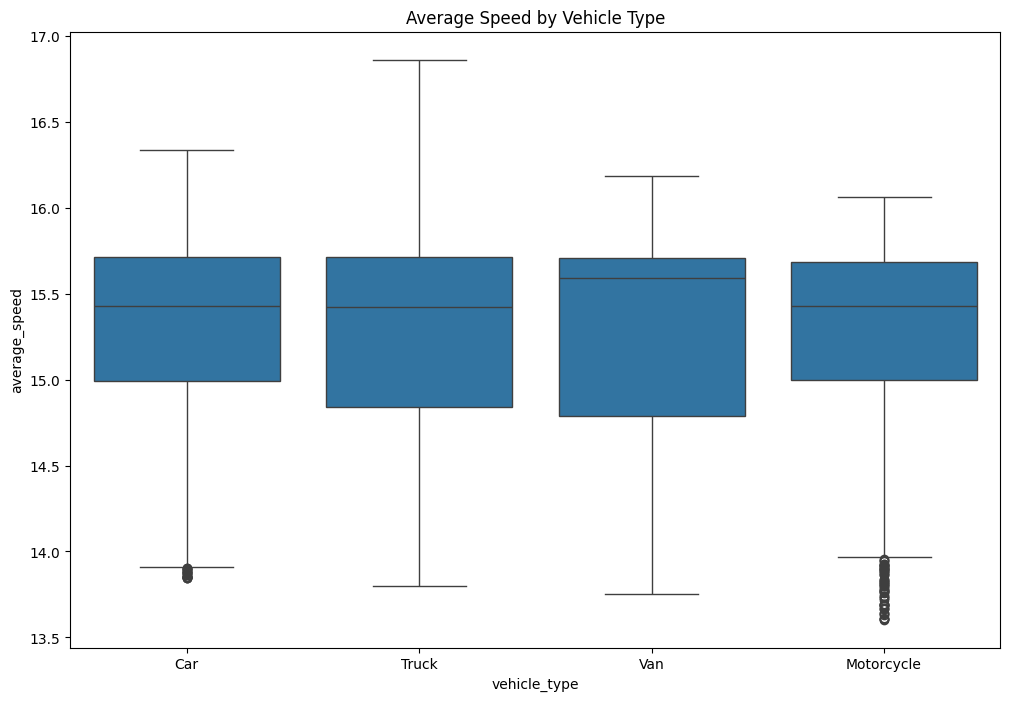

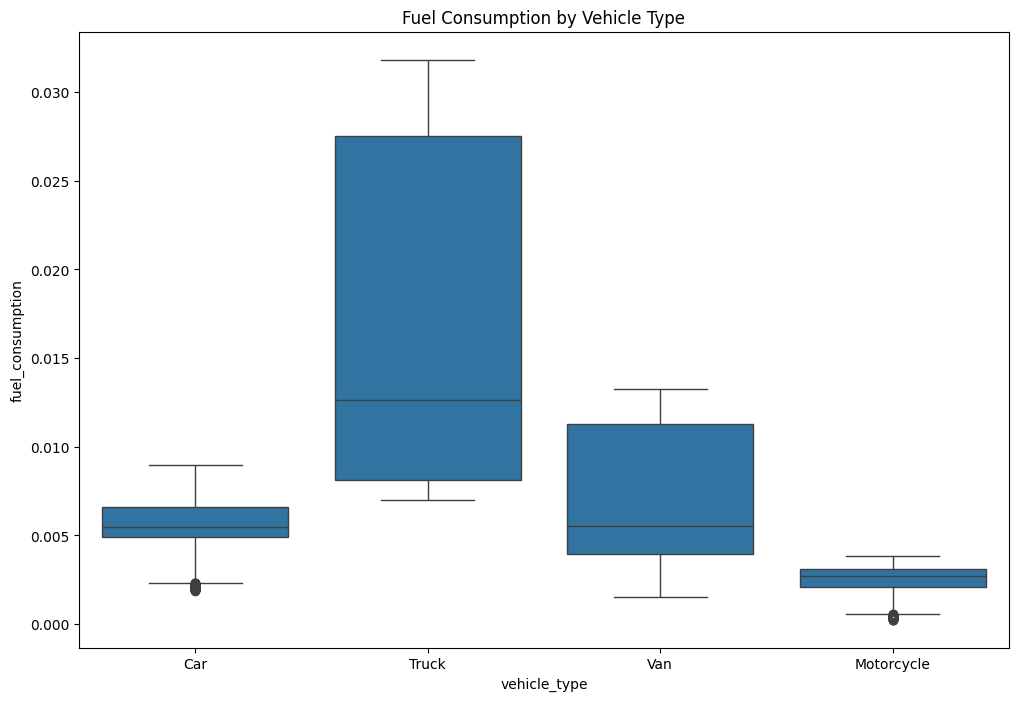

In [ ]:
# Exploratory data analysis - visualize relationship between features and vehicle type
plt.figure(figsize=(12, 8))
sns.boxplot(x='vehicle_type', y='average_speed', data=df)
plt.title('Average Speed by Vehicle Type')
plt.show()

plt.figure(figsize=(12, 8))
sns.boxplot(x='vehicle_type', y='fuel_consumption', data=df)
plt.title('Fuel Consumption by Vehicle Type')
plt.show()


In [ ]:
# Create feature matrix and target vector
X = df.drop(columns=['vehicle_type', 'vehicle_name', 'lap'])  # Remove unnecessary columns
y = df['vehicle_type']


In [ ]:
# Convert lap time to numeric if not already
if 'lap time' in X.columns:
    X = X.rename(columns={'lap time': 'lap_time'})

In [ ]:
# Add target encoding before splitting the data
le_target = LabelEncoder()
y_encoded = le_target.fit_transform(y)
print(f"Encoded class mapping: {dict(zip(le_target.classes_, range(len(le_target.classes_))))}")

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.25, random_state=42, stratify=y_encoded)

# Encode categorical variables if any remain
categorical_cols = X.select_dtypes(include=['object']).columns
for col in categorical_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


Encoded class mapping: {'Car': 0, 'Motorcycle': 1, 'Truck': 2, 'Van': 3}


In [ ]:
# Feature importance-based selection
rf_selector = RandomForestClassifier(n_estimators=100, random_state=42)
rf_selector.fit(X_train_scaled, y_train)

RandomForestClassifier(random_state=42)

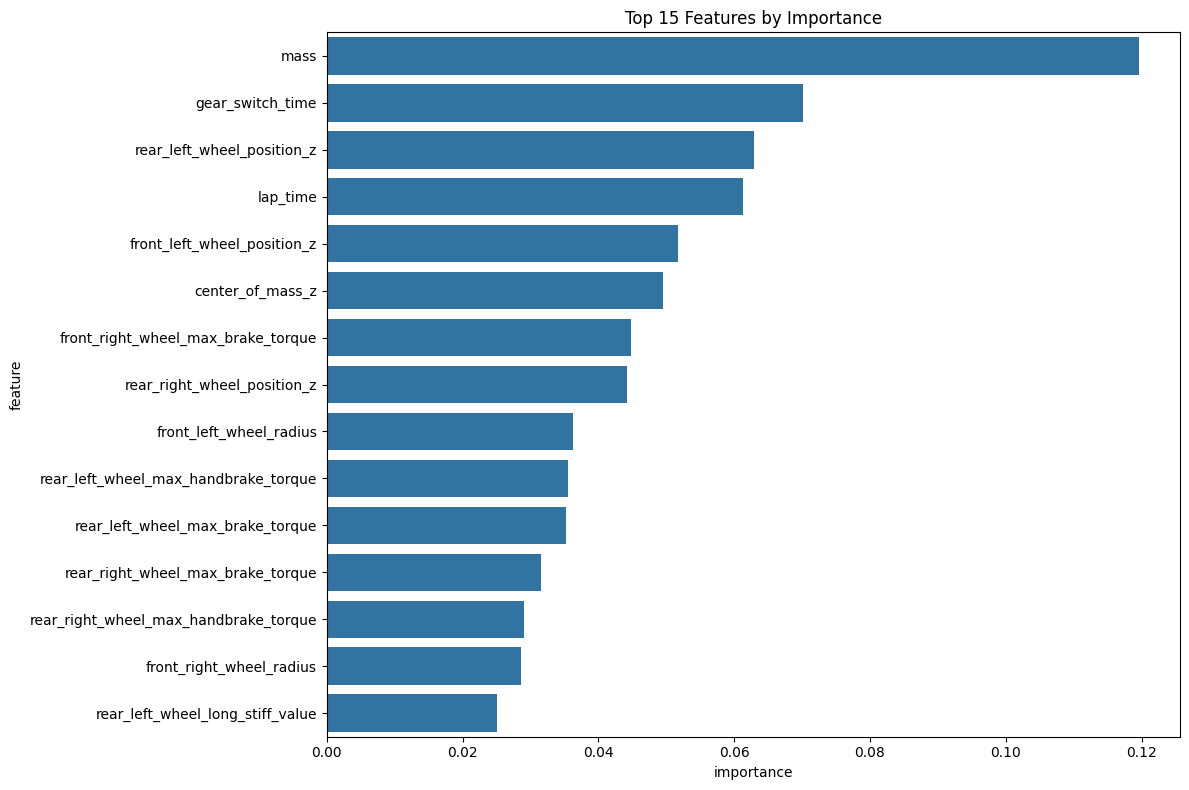

In [ ]:
# Plot feature importance
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_selector.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=feature_importance.head(15))
plt.title('Top 15 Features by Importance')
plt.tight_layout()
plt.show()

In [ ]:
# Select top features
selector = SelectFromModel(rf_selector, prefit=True, threshold='median')
X_train_selected = selector.transform(X_train_scaled)
X_test_selected = selector.transform(X_test_scaled)
selected_features = X.columns[selector.get_support()]
print(f"Selected features: {selected_features}")

Selected features: Index(['fuel_consumption', 'total_steering', 'lap_time', 'mass',
       'center_of_mass_x', 'center_of_mass_z', 'gear_switch_time',
       'front_left_wheel_radius', 'front_left_wheel_max_brake_torque',
       'front_left_wheel_long_stiff_value', 'front_left_wheel_position_z',
       'front_right_wheel_radius', 'front_right_wheel_max_brake_torque',
       'front_right_wheel_long_stiff_value', 'front_right_wheel_position_z',
       'rear_left_wheel_radius', 'rear_left_wheel_max_brake_torque',
       'rear_left_wheel_max_handbrake_torque',
       'rear_left_wheel_long_stiff_value', 'rear_left_wheel_position_z',
       'rear_right_wheel_radius', 'rear_right_wheel_max_brake_torque',
       'rear_right_wheel_max_handbrake_torque',
       'rear_right_wheel_long_stiff_value', 'rear_right_wheel_position_z'],
      dtype='object')


In [ ]:
# Train models with hyperparameter tuning
models = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "XGBoost": XGB.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss'),
    "Naive Bayes": GaussianNB()  # Add Naive Bayes
}


In [ ]:
# Dictionary to store the best models
best_models = {}

# Grid search parameters
param_grids = {
    "Random Forest": {
        'n_estimators': [100, 200, 300],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5, 10]
    },
    "Gradient Boosting": {
        'n_estimators': [100, 200],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7]
    },
    "XGBoost": {
        'n_estimators': [100, 200],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7]
    },
    "Naive Bayes": {
        'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6]  # Add hyperparameter for Naive Bayes
    }
}

In [ ]:
# Perform grid search for each model
for name, model in models.items():
    grid_search = GridSearchCV(
        model,
        param_grids[name],
        cv=5,
        scoring='accuracy',
        n_jobs=-1,
        verbose=1
    )
    grid_search.fit(X_train_selected, y_train)
    
    print(f"Best parameters for {name}: {grid_search.best_params_}")
    print(f"Best cross-validation score: {grid_search.best_score_:.4f}")
    
    best_models[name] = grid_search.best_estimator_


Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best parameters for Random Forest: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}
Best cross-validation score: 1.0000
Fitting 5 folds for each of 18 candidates, totalling 90 fits


In [ ]:
# Evaluate on test set
results = {}
for name, model in best_models.items():
    y_pred = model.predict(X_test_selected)
    accuracy = accuracy_score(y_test, y_pred)
    results[name] = accuracy
    
    print(f"\n{name} Results:")
    print(f"Accuracy: {accuracy:.4f}")
    
    # Convert numeric predictions back to original labels for the classification report
    y_pred_original = le_target.inverse_transform(y_pred)
    y_test_original = le_target.inverse_transform(y_test)
    
    print(classification_report(y_test_original, y_pred_original))
    
    # Plot confusion matrix with original class names
    plt.figure(figsize=(10, 8))
    cm = confusion_matrix(y_test_original, y_pred_original)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=le_target.classes_, 
                yticklabels=le_target.classes_)
    plt.title(f'{name} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()

In [ ]:
# Compare models
plt.figure(figsize=(10, 6))
sns.barplot(x=list(results.keys()), y=list(results.values()))
plt.ylim(0, 1)
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')
plt.tight_layout()
plt.show()

In [ ]:
# Feature importance from the best model
if 'Random Forest' in best_models:
    best_model = best_models['Random Forest']
    feature_imp = pd.DataFrame({
        'Feature': selected_features,
        'Importance': best_model.feature_importances_
    }).sort_values('Importance', ascending=False)
    
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=feature_imp)
    plt.title('Feature Importance from Best Model')
    plt.tight_layout()
    plt.show()

In [ ]:
# Visualize the decision space (using top 2 features)
if len(selected_features) >= 2:
    top_features = feature_imp['Feature'].iloc[:2].values
    top_feature_indices = [list(X.columns).index(feat) for feat in top_features]
    
    plt.figure(figsize=(12, 10))

In [ ]:
from matplotlib.colors import ListedColormap
cmap = ListedColormap(['#FF0000', '#00FF00', '#0000FF', '#FFFF00', '#FF00FF'])

# Get unique vehicle types for coloring
unique_classes = np.unique(y)

# Plot decision regions
x_min, x_max = X_test[:, top_feature_indices[0]].min() - 1, X_test[:, top_feature_indices[0]].max() + 1
y_min, y_max = X_test[:, top_feature_indices[1]].min() - 1, X_test[:, top_feature_indices[1]].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                     np.arange(y_min, y_max, 0.01))

In [ ]:
# Get the best model
best_model_name = max(results, key=results.get)
model = best_models[best_model_name]

Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, alpha=0.4, cmap=cmap)

# Plot the training points
for i, class_value in enumerate(unique_classes):
    indices = np.where(y_test == class_value)
    plt.scatter(X_test[indices, top_feature_indices[0]], 
                X_test[indices, top_feature_indices[1]], 
                alpha=0.8,
                label=class_value)

plt.xlabel(top_features[0])
plt.ylabel(top_features[1])
plt.title(f'Decision Boundary using {best_model_name} (Top 2 Features)')
plt.legend()
plt.show()

In [ ]:

# label_encoders = {}
# for col in df.select_dtypes(include=['object']).columns:
#     le = LabelEncoder()
#     df[col] = le.fit_transform(df[col])
#     label_encoders[col] = le

# df.describe()

# df = df.dropna()
# # Vehicle type classification
# y_vehicle = df['vehicle_type']

# # Lap time classification (Fast, Medium, Slow)
# def categorize_lap_time(time):
#     if time <= 42.5:
#         return 'Fast'
#     elif 42.5 < time <= 45:
#         return 'Medium'
#     else:
#         return 'Slow'
    
# df['lap_time_category'] = df['lap time'].apply(categorize_lap_time)
# y_lap = df['lap_time_category']
# # Splitting features and labels
# X = df.drop(columns=['vehicle_type', 'lap time', 'lap_time_category'])
# # X = df.drop(columns=['vehicle_type'])  # Replace 'target_column' with actual target column name
# y = df['vehicle_type']  # Replace 'target_column' with actual target column name


# y_lap = LabelEncoder().fit_transform(y_lap)
# y_vehicle = df['vehicle_type']
# y = LabelEncoder().fit_transform(y)

# # Splitting features and labels
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
# # X_train_lap, X_test_lap, y_train_lap, y_test_lap = train_test_split(X, y_lap, test_size=0.3, random_state=42)

# print(df['vehicle_type'].value_counts())
# # Feature scaling
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)
# models = {
#     'Decision Tree': DecisionTreeClassifier(max_depth=10, min_samples_split=5),
#     'Naive Bayes': GaussianNB(),
#     'XGBoost': XGBClassifier(n_estimators=120, learning_rate=0.1, use_label_encoder=False, eval_metric='logloss'),
#     'Random Forest': RandomForestClassifier(n_estimators=200, max_depth=15)
# }

# from sklearn.model_selection import cross_val_score

# # Train and evaluate models for vehicle type classification
# fig, axes = plt.subplots(2, 2, figsize=(12, 12))
# fig.suptitle("\nVehicle Type Classification Results", fontsize=14)

# class_names = df['vehicle_type'].unique().tolist()
# class_names = [str(name) for name in class_names]  # Convert class names to strings

# for i, (name, model) in enumerate(models.items()):
#     model.fit(X_train, y_train)
#     y_pred = model.predict(X_test)
#     print(f'\n{name} Classification Report:\n', classification_report(y_test, y_pred))
    
# # Perform cross-validation
# for name, model in models.items():
#     scores = cross_val_score(model, X, y, cv=5)
#     print(f'{name} Cross-Validation Scores: {scores}')
#     print(f'{name} Mean Cross-Validation Score: {scores.mean()}')

# # Train and evaluate models for vehicle type classification
# fig, axes = plt.subplots(2, 2, figsize=(12, 12))
# fig.suptitle("\nVehicle Type Classification Results", fontsize=14)

# for i, (name, model) in enumerate(models.items()):
#     model.fit(X_train, y_train)
#     y_pred = model.predict(X_test)
#     print(f'\n{name} Classification Report:\n', classification_report(y_test, y_pred, target_names=class_names))
    
#     # Confusion Matrix Visualization
#     cm = confusion_matrix(y_test, y_pred)
#     sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i//2, i%2], xticklabels=class_names, yticklabels=class_names)
#     axes[i//2, i%2].set_title(f'{name} Confusion Matrix')
#     axes[i//2, i%2].set_xlabel('Predicted')
#     axes[i//2, i%2].set_ylabel('Actual')

# plt.tight_layout()
# plt.show()

# # for i, (name, model) in enumerate(models.items()):
# #     model.fit(X_train_lap, y_train_lap)
# #     y_pred = model.predict(X_test_lap)
# #     print(f'\n{name} Classification Report:\n', classification_report(y_test_vehicle, y_pred))
    
#     # # Confusion Matrix Visualization
#     # sns.heatmap(confusion_matrix(y_test_vehicle, y_pred), annot=True, fmt='d', cmap='Blues', ax=axes[i//2, i%2])
#     # axes[i//2, i%2].set_title(f'{name} Confusion Matrix')
#     # axes[i//2, i%2].set_xlabel('Predicted')
#     # axes[i//2, i%2].set_ylabel('Actual')

# plt.tight_layout()
# plt.show()
# # Convert pandas DataFrame to numpy array for plotting
# X_np = X.to_numpy()  # Convert DataFrame to numpy array
# X_2d = X_np[:, [0, 1]]  # Now we can use numpy indexing

# # Create a figure with subplots for each classifier
# fig, axes = plt.subplots(2, 2, figsize=(15, 15))
# fig.suptitle('Classification Results Visualization', fontsize=16)

# # Plot for each model
# for idx, (name, model) in enumerate(models.items()):
#     # Get predictions
#     y_pred = model.predict(X_test)
    
#     # Calculate subplot position
#     i, j = idx // 2, idx % 2
    
#     # Create scatter plot
#     scatter = axes[i,j].scatter(X_test[:, 0], X_test[:, 1], 
#                                c=y_pred, 
#                                cmap='viridis', 
#                                alpha=0.6)
    
#     # Add labels and title
#     axes[i,j].set_xlabel('Average Speed')
#     axes[i,j].set_ylabel('Fuel Consumption')
#     axes[i,j].set_title(f'{name} Classification')
    
#     # Add colorbar
#     plt.colorbar(scatter, ax=axes[i,j])

# plt.tight_layout()
# plt.show()

# # Additional plot showing actual classes for comparison
# plt.figure(figsize=(8, 8))
# scatter = plt.scatter(X_test[:, 0], X_test[:, 1], 
#                      c=y_test, 
#                      cmap='viridis', 
#                      alpha=0.6)
# plt.colorbar(scatter)

# plt.title('Actual Classes')
# plt.show()